In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [3]:
from numba import jit #enables just in time compiling and parallel (if possible) computing


@jit(nopython=True, parallel=True)
def evo(Ai, Bi, timestep, tau):
    deleted = 0
    Aevo = []
    Bevo = []
    A=Ai
    while A>0:
        for i in range(A):
            if np.random.uniform(0,1)<(1-2**(-(timestep)/tau)):
                deleted +=1
        A = int(Ai-deleted)
        B = int(Bi+deleted)
        Aevo.append(A)
        Bevo.append(B)       
    return Aevo,Bevo
        
    
Tl = 10000
Pb = 0
timestep = 1
tau = 3.052*60
   
Tl_evo, Pb_evo = evo(Tl,Pb,timestep,tau)

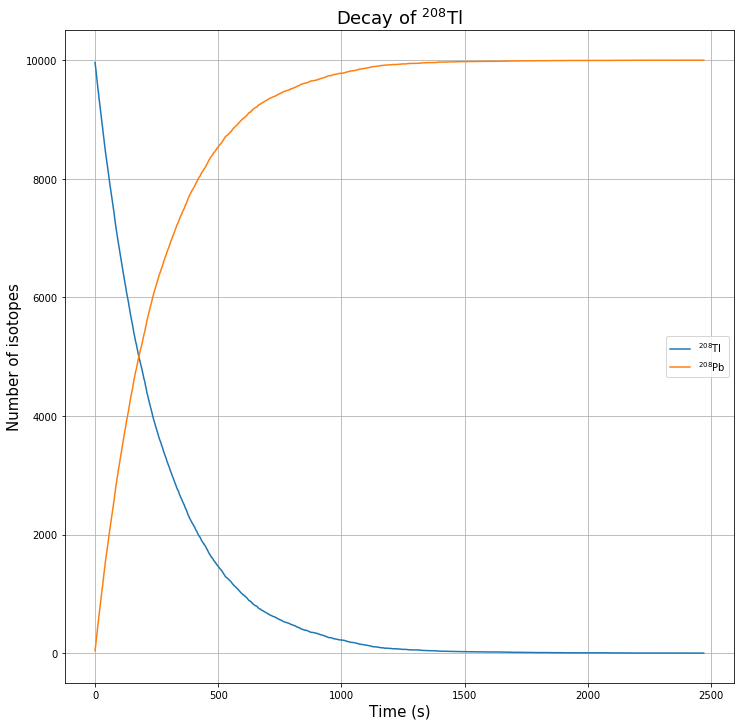

2470


In [6]:
x = np.linspace(0,len(Tl_evo)*timestep,len(Tl_evo))
plt.figure(figsize=(12,12))
plt.plot(x, Tl_evo, label=r'$^{208}$Tl')
plt.plot(x, Pb_evo, label=r'$^{208}$Pb')
plt.title(r"Decay of $^{208}$Tl", fontsize=18)
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Number of isotopes', fontsize=15)
plt.grid()
plt.legend()
plt.show()
print(len(Tl_evo))

Text(0, 0.5, 'Number of Tl isotopes')

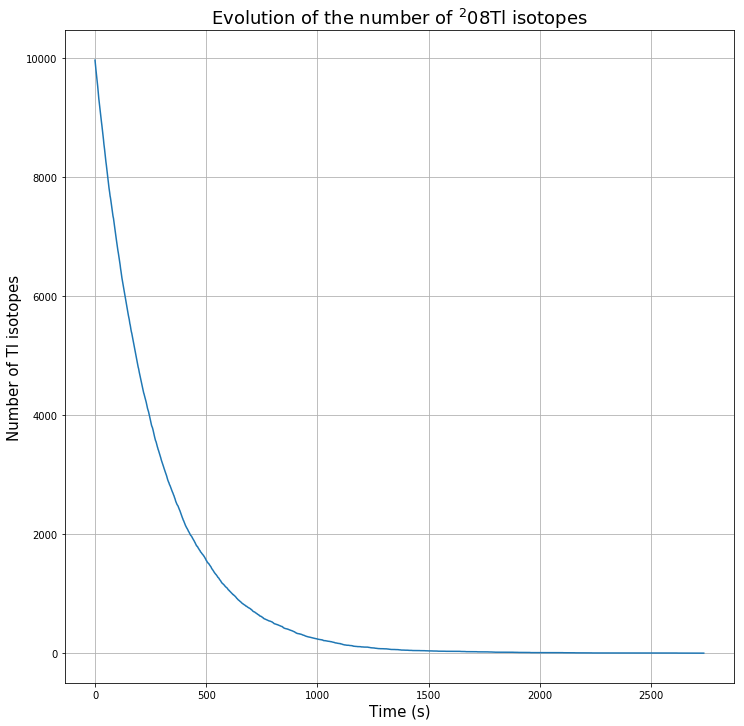

In [8]:
from numba import jit

@jit(nopython=True, parallel=True)
def evotimes(N, tau, tstep):
    T = []
    surviving = []
    s=N
    mu = np.log(2)/tau
    
    def prob(mu):
        return (-1/mu)*np.log(1-np.random.rand())
    
    for i in range(N):
        T.append(prob(mu))  
        
    t=0  
    while s>0:
        t+=tstep
        s=N
        for i in range(N):
            if T[i]<t:
                s-=1           
        surviving.append(s)       
    return T,surviving
        

tau = 3.052*60
N = 10000
tstep = 1

tm, Evo = evotimes(N, tau, tstep)
times = np.arange(0,len(Evo))
plt.figure(figsize=(12,12))
plt.title(r"Evolution of the number of $^208$Tl isotopes", fontsize=18)
plt.plot(times, Evo, label=r'$^208$Tl')
plt.grid()
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Number of Tl isotopes', fontsize=15)
#plt.plot(np.arange(1000),tm)

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Compute the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [5]:
#we suppose that the gold atom is in the origin of the coordinate system.
#The gaussian beam then is centered around the origin itself.
#the impact parameter is the "real" random variable, which can be extracted via Box Muller method.

from numba import jit

@jit(nopython=True, parallel=True)
def theta_fraction(N, thresh, std, E, Z):
    
    E = e*E                  #Joule
    frac=0
    
    #to calculate b
    def imp_par(std):
        return (-2*(std**2)*np.log(1-np.random.rand()))**(1/2)
                
    #to calculate theta            
    def theta(Z,E,std):
        return (2*np.arctan((Z*e*e)/(2*np.pi*eps_0*E*imp_par(std))))        
                           
    for i in range(N):
        if theta(Z,E,std)>thresh:
                frac+=1
    
    return (frac/N)            
    

                
                
#constants             
e = 1.6022*10**-19       #Coulomb
a_0 = 5.292*10**-11      #meters                
eps_0 = 8.8542*10**-12   #Faraday/meter                
    
    
thresh = np.pi/2   #threshold angle
E = 7.7*10**6        #energy in MeV
std = a_0/100        #std of the beam  
Z = 79               #mass number of the target
N = 1000000          #number of alpha particles

f = theta_fraction(N, thresh, std, E, Z)                
print('The fraction of alpha particles that bounced back is ',f)   

The fraction of alpha particles that bounced back is  0.001529


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [7]:
from numba import jit


#Monte Carlo
@jit(nopython=True, parallel=True)
def integral_MC(a,b,N):
    
    def func(x):
        return (np.sin(1/(x*(2-x))))**2
    
    res = 0
    for i in range(N):
        if np.random.rand()<func(np.random.uniform(a,b)):
            res+=1
    
    return  res*(b-a)/(N), N**0.5



#mean value
@jit(nopython=True, parallel=True)
def integral_mv(a,b,N):
    
    def func(x):
        return (np.sin(1/(x*(2-x))))**2
    
    res = 0
    for i in range(N):
        res+=func(np.random.uniform(a,b))
    
    return  (res*(b-a))/(N), (b-a)/(N**0.5)

#ERRORS

a = 0 
b = 2
N = 10000000

MC, err_MC = integral_MC(a,b,N)
mv, err_mv = integral_mv(a,b,N)

print('Monte Carlo integration yielded the following result: ',MC, 'with error: ',err_MC)
print('No good')
print('Mean value integration yielded the following result: ',mv, 'with error: ',err_mv)






Monte Carlo integration yielded the following result:  1.4511194 with error:  3162.2776601683795
No good
Mean value integration yielded the following result:  1.451496168439752 with error:  0.0006324555320336759


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [8]:
from numba import jit

@jit(nopython=True, parallel = True)
def monte_circle(N, radius=1.0):
    res = 0
    for i in range(N):
        x = np.random.rand()
        y = np.random.rand()
        if (x**2 + y**2) < radius:
            res += 1
    return (4.0 * radius * res) / N

print(monte_circle(100000))

#only performs Monte Carlo on a d-dimensional clove of a d dimensional  sphere
@jit(nopython=True, parallel = True)
def monte_ball(N, d=2, radius=1.0):
    res = 0
    for i in range(N):
        x = np.random.rand(d)
        if x.dot(x.T) < radius:
            res += 1
    return (((2 * radius)**d) * res) / N

res = monte_ball(10000000, 10)
print('Volume of a 10d sphere according to Monte Carlo calculation: ',res) 
print('Volume of a 10d sphere according to real maths: ',np.pi**5/120) 
print("10d error: ", np.abs(np.pi**5/120-res))

3.13908
Volume of a 10d sphere according to Monte Carlo calculation:  2.5501696
Volume of a 10d sphere according to real maths:  2.550164039877345
10d error:  5.560122654735267e-06


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [7]:
from numba import jit

@jit(nopython=True, parallel = True)
def important_integral(a,b,N):
    
    def func(x):
        return (x**(-0.5))/(np.exp(x)+1)

    def weight(x):
        return x**(-0.5)
    
    
    #may be converted to approximate integral if necessary
    def int_weight(a,b):
        return (2*(b**(0.5)-a**(0.5)))
    
    res = 0
    for i in range(N):
        x=np.random.rand()
        res+=(func(x)/weight(x))
    
    return ((res*int_weight(a,b))/N)
    
    
a = 0   
b = 1
N = 1
    
I = important_integral(a,b,N)
    
print('Importance sampling Monte Carlo method yielded the following result for the integral at hand: ',I)    

    

Importance sampling Monte Carlo method yielded the following result for the integral at hand:  0.6983244254656747
